In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('OutputFeatures.csv')
features_to_disregard = ['Material', 'Feature6', 'Feature7', 'Feature8', 'Feature15']
df = df.drop(columns=features_to_disregard)

In [3]:
df.head()

,Target1,Property,Feature2,Feature3,Feature4,Feature5,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14
0,568.0,YS,18.9,bar,100,longitudinal,979,111,739,222,600,1000
1,479.0,YS,300.0,bar,100,longitudinal,979,111,739,222,600,1000
2,453.0,YS,400.0,bar,100,longitudinal,979,111,739,222,600,1000
3,404.0,YS,500.0,bar,100,longitudinal,979,111,739,222,600,1000
4,284.0,YS,600.0,bar,100,longitudinal,979,111,739,222,600,1000


In [4]:
categorical_features = ['Property', 'Feature3', 'Feature5']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df_encoded.head()

,Target1,Feature2,Feature4,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Property_UE,Property_US,Property_YS,Feature3_plate,Feature5_radial,Feature5_transverse
0,568.0,18.9,100,979,111,739,222,600,1000,0,0,1,0,0,0
1,479.0,300.0,100,979,111,739,222,600,1000,0,0,1,0,0,0
2,453.0,400.0,100,979,111,739,222,600,1000,0,0,1,0,0,0
3,404.0,500.0,100,979,111,739,222,600,1000,0,0,1,0,0,0
4,284.0,600.0,100,979,111,739,222,600,1000,0,0,1,0,0,0


In [5]:
y_unscaled = df_encoded['Target1']
X_unscaled= df_encoded.drop(columns=['Target1'])

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X_unscaled)
y = scaler_y.fit_transform(y_unscaled.values.reshape(-1, 1)).flatten()

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

print(f"X tensor shape: {X.shape}")
print(f"y tensor shape: {y.shape}")

NumberFeatures = X.shape[1]

X tensor shape: torch.Size([530, 14])
y tensor shape: torch.Size([530, 1])


In [6]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size1)
        self.fc4 = nn.Linear(hidden_size1, output_size)
    def forward(self, x):
        # 14
        x = self.relu(self.fc1(x))
        # hidden_size1 = 32
        x = self.relu(self.fc2(x))
        # hidden_size2 = 64
        x = self.relu(self.fc3(x))
        # hidden_size1 = 32
        x = self.fc4(x)
        # output_size = 1
        return x

In [7]:
dataset = TensorDataset(X,y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
learning_rate = 4e-3
weight_decay = 1e-5
model = Model(input_size=NumberFeatures, hidden_size1=32, hidden_size2=64, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [10]:
epochs = 50
Losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    Losses.append(total_loss)  
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')

Epoch [5/50], Loss: 0.0793
Epoch [10/50], Loss: 0.0209
Epoch [15/50], Loss: 0.0128
Epoch [20/50], Loss: 0.0079
Epoch [25/50], Loss: 0.0083
Epoch [30/50], Loss: 0.0056
Epoch [35/50], Loss: 0.0061
Epoch [40/50], Loss: 0.0050
Epoch [45/50], Loss: 0.0062
Epoch [50/50], Loss: 0.0053


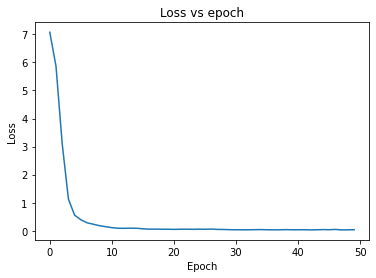

In [11]:
plt.plot(Losses)
plt.title("Loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [12]:
model.eval()
test_loss = 0
Pred=[]
with torch.no_grad():
    for test_X, test_y in test_dataset:
        predictions = model(test_X)
        loss = criterion(predictions, test_y)
        test_loss += loss.item()
        Pred.append(scaler_y.inverse_transform([predictions.detach().numpy()])[0][0])

print(f'Test Loss: {test_loss / len(test_dataset):.4f}')

Test Loss: 0.0069


In [13]:
x_test, y_test = zip(*test_dataset)
y_test = torch.tensor(y_test)
x_test = torch.stack(x_test)

y_test_original = scaler_y.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()
x_test_original = scaler_X.inverse_transform(x_test.numpy())

colors = []
for row in x_test_original.T[9:12].T:
    if row[0] == 1:
        colors.append(1)
    elif row[1] == 1:
        colors.append(2)
    elif row[2] == 1:
        colors.append(3)
    else:
        colors.append(4)

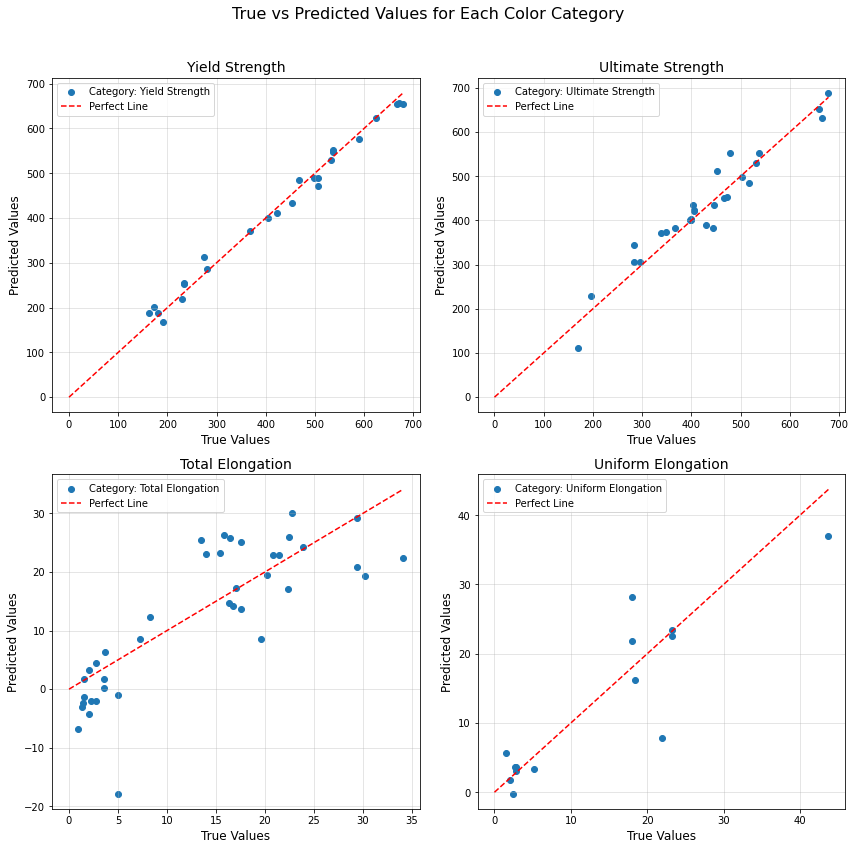

In [14]:
unique_colors = np.unique(colors)

# Create subplots (2 rows x 2 columns for 4 subplots)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("True vs Predicted Values for Each Color Category", fontsize=16)

TargetLabels = ["Yield Strength", "Ultimate Strength", "Total Elongation", "Uniform Elongation"]
for i, color in enumerate(unique_colors):
    ax = axs[i // 2, i % 2]  # Position in 2x2 grid
    mask = colors == color 
    ax.scatter(
        y_test_original[mask],
        np.array(Pred)[mask],
        label=f"Category: {TargetLabels[i]}",
        marker="o",
    )
    ax.plot([0, max(y_test_original[mask])], [0, max(y_test_original[mask])], color="red", linestyle="--", label="Perfect Line")
    ax.set_title(f"{TargetLabels[i]}", fontsize=14)
    ax.set_xlabel("True Values", fontsize=12)
    ax.set_ylabel("Predicted Values", fontsize=12)
    ax.grid(alpha=0.4)
    ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.show()

In [15]:
def input_parameters(
        target_type,
        shape,
        size,
        orientation,
        austenitizing_temp,
        austenitizing_time,
        tempering_temp,
        tempering_time,
        aging_temp,
        aging_time
):
    
    if target_type == "US" or target_type == "YS":
        temp = np.arange(0,700,5)
    elif target_type == "TE" or target_type == "UE":
        temp = np.arange(0,50,1)
        
    base_array = [0, target_type, 0, shape, size, orientation, austenitizing_temp , austenitizing_time, tempering_temp, tempering_time, aging_temp, aging_time]
    input = np.array(base_array*len(temp)).reshape(-1, 12)
    input[:, 2] = temp
    
    
    NewInput = pd.DataFrame(input, columns=df.columns)
    Newdf = pd.concat([df, NewInput], ignore_index=True)
    
    
    Newdf_encoded = pd.get_dummies(Newdf, columns=['Property', 'Feature3', 'Feature5'], drop_first=True)
    Newdf_encoded = Newdf_encoded.drop(columns=['Target1'])
    Newdf_encoded = Newdf_encoded.tail(len(temp))
    
    inputx_scale = scaler_X.transform(Newdf_encoded)
    return inputx_scale, temp

In [16]:
inputx_scale, temp = input_parameters(
    target_type = 'YS', 
    shape = 'bar',
    size = 100,
    orientation = 'longitudinal',
    austenitizing_temp = 979,
    austenitizing_time = 111,
    tempering_temp = 739,
    tempering_time = 222,
    aging_temp = 600,
    aging_time = 1000
)

In [17]:
inputx_scale

array([[-1.74584254,  1.60966556, -0.31861966, ..., -1.71907646,
        -0.12379689, -0.71111308],
       [-1.72335009,  1.60966556, -0.31861966, ..., -1.71907646,
        -0.12379689, -0.71111308],
       [-1.70085765,  1.60966556, -0.31861966, ..., -1.71907646,
        -0.12379689, -0.71111308],
       ...,
       [ 1.33562195,  1.60966556, -0.31861966, ..., -1.71907646,
        -0.12379689, -0.71111308],
       [ 1.35811439,  1.60966556, -0.31861966, ..., -1.71907646,
        -0.12379689, -0.71111308],
       [ 1.38060683,  1.60966556, -0.31861966, ..., -1.71907646,
        -0.12379689, -0.71111308]])

In [18]:
predictions = model(torch.tensor(inputx_scale,dtype=torch.float32))
y_original = scaler_y.inverse_transform(predictions.detach().numpy().reshape(-1, 1)).flatten()

NameError: name 'target_type' is not defined

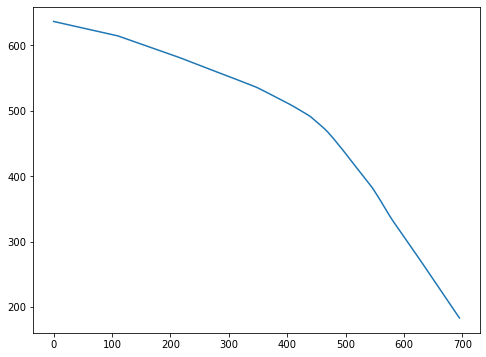

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(temp,y_original, label = "Pred")
plt.title(f"{target_type} vs Temp")
plt.xlabel("temp")
plt.ylabel(target_type)
plt.grid()
plt.show()
